**Project name**: Forecasting Energy Consumption in Siberia Notebook 1 (2021)

**Author** : Seydou DIA

**Last update**: 02-18-2021

**Entire notebook running time**: 28s <br>
with AMD Ryzen 7 3750H - Radeon Vega Mobile Gfx 2.30 GHz

**Conctact**:<br>
* [Linkedin](https://www.linkedin.com/in/seydou-dia-325b04139)
* @:seydou.dia@insa-lyon.fr

For more projects on Data Science and energy click here >
[Data Science Portfolio](https://seydoudia.github.io/Data-Science-portfolio/)

# Description

Predicting energy consumption can be very important for grid operators who need to ensure balance between electricity consumption and production at all times. One of the methods used to achieve this equilibrium is to forecast the energy consumption for the following 10 minutes, hour, day, month or even year to best manage production assets. 
In a context of massive development of intermittent energies, forecasting energy consumption accurately has never been that important.

In response to these issues, the goal of these project series is to explore different kind of energy consumption forecasting methods under the form of timeseries data.

The project series is divided into three different notebooks where we will be exploring three forecasting methods:

- **Notebook 1 :** SARIMA <br>
- **Notebook 2 :** XGBoost Regresor<br>
- **Notebook 3 :** LASSO Regularised Regression<br>



This Notebook is exploring the SARIMA Forecasting method and is divided into four different parts. In part one a small data processing is carried out and then an analysis of the data is performed in part two. A statistical study of our signal is carried out in part 3 before building and evaluating the SARIMA model in part 4.


*References used to conduct this project can be found at the end of the notebook. Also, a few functions were developped for this work and their entire code as well their docstring can be find in the Functions section at the beginning of the notebook*

In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Imports

In [92]:
# os related
from os import environ as env
from os.path import join
from os import cpu_count
import multiprocessing

# data related
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import timedelta

# visual related
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.colors

# stats related
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# miscellaneous
from math import sqrt
from time import time

# Paths

In [93]:
DIR_ROOT = join(env["CODE_PATH"], "ARIMA") # project path
DIR_CODE = join(DIR_ROOT, "Code") # code path
DIR_RAW = join(DIR_ROOT, 'Raw Data') # raw data path

CONS_PATH = join(DIR_RAW, 'RU_Electricity_Market_PZ_dayahead_price_volume.csv')

# Functions

These functions have been developped to ease the analysis of the ADF test as well as both ACF and PACF plot. If the reader wants to understand to code behind it, he or she can come back to these cells below later on.

In [3]:
def print_adf(tpl_adf):
    """This function prints the results of the ADF test
    Parameters
    ----------
    tpl_adf(tuple): tuple returned from adf_test function above
    
    Returns
    ----------
     None"""
    
    dfout = pd.Series(tpl_adf[0:4], 
                      index=['Test Statistic', 'p-value', '#Lags Used', 
                             'Number of Observation Used'])
    print(dfout)
    
    for k, v in tpl_adf[4].items():
        print('Critical value {}: {}'.format(k, v))
    return
        

In [4]:
def adf_test(timeseries, autolag='AIC', out=False):
    """This fucntion performs the augmented dicky fuller test on a given
    timeseries. It uses the adfuller function from statsmodels.tsa.stattools
    
    Parameters
    ----------
    timeseries(Pd.Series/list): timeseries to perform the test on.
    autolag(String):  Method to use when automatically determining the lag.
    out(Bool): if True, the result will be returned in a tuple. Else the results
               will only be printed directly in the function.
               
    Returns
    ----------
     None if out == True else returns tuple with results"""
    
    test_result = adfuller(timeseries, autolag=autolag)
    print_adf(test_result)
    
    if out:
        return test_result
    else:
        return
    

In [5]:
def plot_cf(timeseries, lags=15):
    
    """This fucntion plots both ACF and PACF of a given timeseries with confidence interval.
    
    Parameters
    ----------
    timeseries(pd.Series/list): timeseries on which the ACF and PACF will be applied
    lags(integer): maximum lag to plot
    
    Returns
    ----------
    None
    """
    
    arr_acf, confint_acf = acf(timeseries, nlags=lags, alpha=0.05)
    arr_pacf, confint_pacf = pacf(timeseries, nlags=lags, alpha=0.05)
    
    
    print(len(arr_acf))
    fig, axs = plt.subplots(2, 1, sharex=True,
                        figsize=(7, 7))
    
    
    x_lags = [float(i) for i in range(lags+1)]
    
    x_lags[0] -= 0.5
    x_lags[-1] += 0.5
     
    
    # ACF Plot
    acf_ax = axs[0]
    acf_ax.bar(range(lags+1), arr_acf)
    acf_ax.plot()
    acf_ax.set_ylim(-1.2,1.2)
    acf_ax.fill_between(x_lags, confint_acf[:, 0] - arr_acf, 
                        confint_acf[:, 1] - arr_acf, 
                        alpha=0.25,color='b')
    acf_ax.title.set_text('ACF Plot')
    
    
    # PACF Plot
    pacf_ax = axs[1]
    pacf_ax.bar(range(lags+1), arr_pacf)
    pacf_ax.title.set_text('PACF Plot')
    pacf_ax.fill_between(
        x_lags, confint_pacf[:, 0] - arr_pacf, 
        confint_pacf[:, 1] - arr_pacf, 
        alpha=0.25, color='b')
    
    return


# Reading and Preprocessing data

In [7]:
df = pd.read_csv(CONS_PATH)

In [8]:
df.head(5)

,timestep,consumption_eur,consumption_sib,price_eur,price_sib
0,2006-09-01 00:00,62341.0,17916.0,275.22,0.0
1,2006-09-01 01:00,60625.0,17467.0,0.00,0.0
2,2006-09-01 02:00,59685.0,17161.0,0.00,0.0
3,2006-09-01 03:00,59500.0,17061.0,0.00,0.0
4,2006-09-01 04:00,60617.0,17074.0,0.00,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45816 entries, 0 to 45815
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestep         45816 non-null  object 
 1   consumption_eur  45816 non-null  float64
 2   consumption_sib  45816 non-null  float64
 3   price_eur        45816 non-null  float64
 4   price_sib        45816 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.7+ MB


The Russian electric market is divided into several zones where each hour a price is determined.

By looking at our dataset, we can see that we have four different columns each sampled at an hourly timstep.
Each column informs us about the hourly consumption and electricity price of two "electric zones".
price_xxx and consumption_xxx respectively represent the aggregated consumption and price of the entire Euro and Siberian zone. In this project series we will only be focusing on the prediction of electricity consumption in Siberia.

Although it is not specified on the dataset, the energy consumption units in this dataset are in MWh. More information about this dataset can be found here : https://www.kaggle.com/irinachuchueva/russian-wholesale-electricity-market

After having loaded the dataset, it seems that there aren't any missing values since out of 45816 entries, we have 45816 non-null cells for all 4 columns.


Before jumping to a deeper analysis of the energy consumption in Siberia, let's do a bit of processing on our dataset, to make it more convenient to manipulate.

In [10]:
# A processing of the timestep column is necessary in 
# order to convert it to datetime and set it as an index of our dataset

index = df['timestep'].values
index = [dt.datetime.strptime(d, '%Y-%m-%d %H:%M') for d in index] # Conversion 
                                                                   # to datetime 

df.drop(columns=['timestep'], inplace=True)

df.index = index

In [11]:
df.head(5)

,consumption_eur,consumption_sib,price_eur,price_sib
2006-09-01 00:00:00,62341.0,17916.0,275.22,0.0
2006-09-01 01:00:00,60625.0,17467.0,0.00,0.0
2006-09-01 02:00:00,59685.0,17161.0,0.00,0.0
2006-09-01 03:00:00,59500.0,17061.0,0.00,0.0
2006-09-01 04:00:00,60617.0,17074.0,0.00,0.0


# First Plots & Analysis

<IPython.core.display.Javascript object>


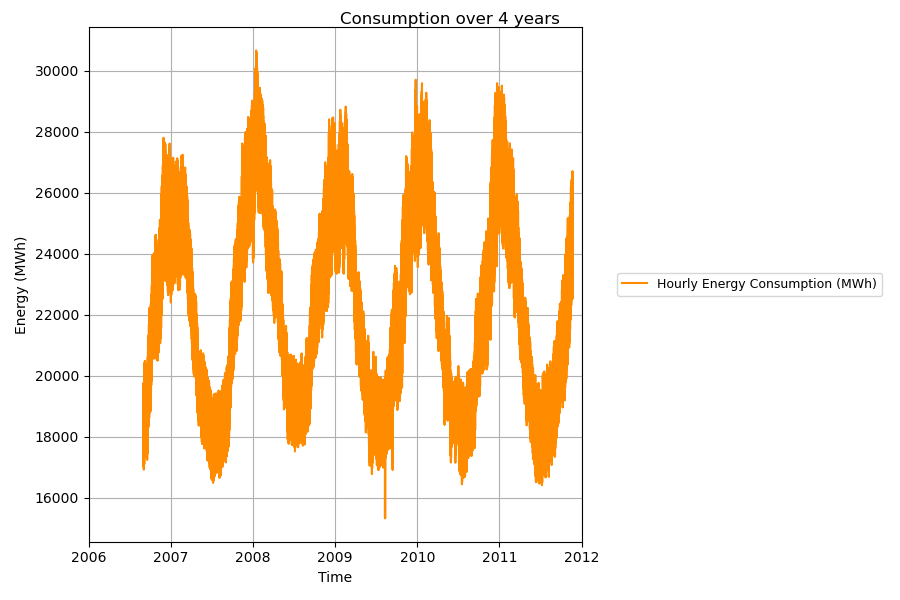

In [12]:
start = "2006-12-01 00:00:00"
end = "2006-12-01 23:00:00"


df_plot = df[:]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(df_plot.index, df_plot["consumption_sib"], 
         label="Hourly Energy Consumption (MWh)",
         color="darkorange", linewidth=1.5)

#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
pax.xaxis.set_major_locator(years)
pax.xaxis.set_major_formatter(years_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'Y')
datemax = np.datetime64(df_plot.index[-1], 'Y') + np.timedelta64(1, 'Y')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Energy (MWh)")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Consumption over 4 years")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])

As we can see on the plot above, energy consumption in Siberia as sinusoidal shape accros the years with a consumption peak during winters and less consumption during summer. Energy seems to fluctuate between 17000 MWh and 30000MWh between the year 2006 and 2011. There doesn't seem to be any positive or negative trend in the consumption since the level of the sinewave looks pretty constant.

Although we extracted these first information from the plot, it is very noisy due to the hourly timestep of the data. This can make it very difficult to build a good monthly forecasting model.
Let's use the describe function that enables us to have a first glimpse of the statistical features of our data.

In [94]:
df.describe()[['consumption_sib']]

,consumption_sib
count,45816.000000
mean,22297.937294
std,3035.991381
min,15328.674800
25%,19697.000000
50%,22057.000000
75%,24788.054198
max,30666.000000


It is interesting to notice that energy consumption ranged between 15328 MWh and 30666 MWh between 2006 and 2011
. This is already an interesting information for grid operators that know what could be the minimum and maximum of energy flowing through the network. Moreover, we can see that we have a standard deviation of only 3035 MWh which is not that much when we consider that we are dealing with energy consumption data accros multiple years.

In order to carry out a more relevant analysis, let us plot the rolling average daily, weekly and yearly.

In [95]:
df['rol_mean_day'] = df['consumption_sib'].rolling(window=24).mean()
df['rol_mean_week'] = df['consumption_sib'].rolling(window=24*7).mean()
df['rol_mean_month'] = df['consumption_sib'].rolling(window=24*7*30).mean()
df['rol_mean_year'] = df['consumption_sib'].rolling(window=24*7*4*12).mean()
df['rol_std_day'] = df['consumption_sib'].rolling(window=24).std()
df['rol_std_year'] = df['consumption_sib'].rolling(window=24*7*4*12).std()


<IPython.core.display.Javascript object>


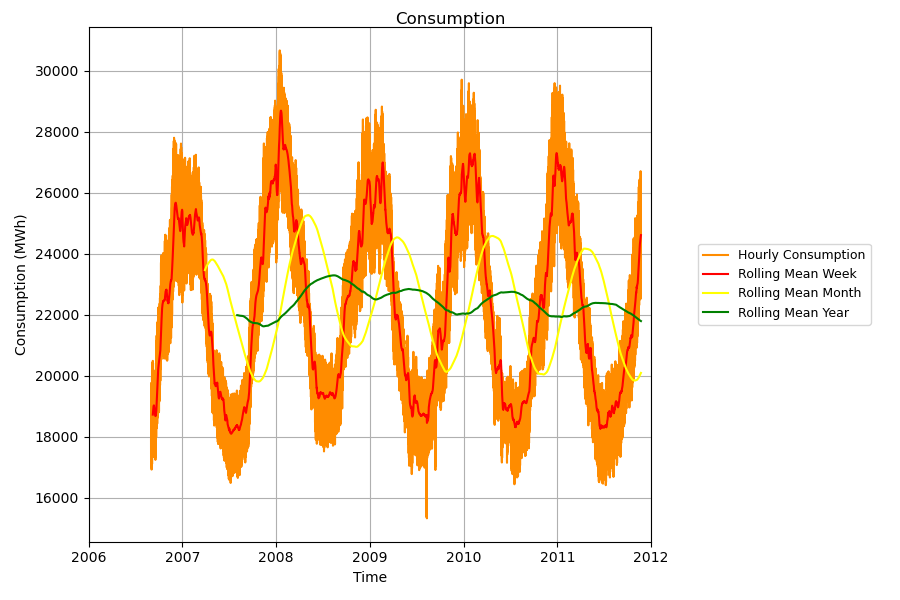

In [96]:
start = "2006-12-01 00:00:00"
end = "2006-12-01 23:00:00"


df_plot = df[['consumption_sib', 'rol_mean_day',
              'rol_mean_week', 'rol_std_day', 
              'rol_mean_month', 'rol_mean_year',
             'rol_std_year']][:]

# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(df_plot.index, df_plot["consumption_sib"], label="Hourly Consumption",
         color="darkorange", linewidth=1.5)

#pax.plot(df_plot.index, df_plot["rol_mean_day"], label="Rolling Mean Day",
#         color="blue", linewidth=1.5)

pax.plot(df_plot.index, df_plot["rol_mean_week"], label="Rolling Mean Week",
         color="red", linewidth=1.5)

pax.plot(df_plot.index, df_plot["rol_mean_month"], label="Rolling Mean Month",
         color="yellow", linewidth=1.5)

pax.plot(df_plot.index, df_plot["rol_mean_year"], label="Rolling Mean Year",
         color="green", linewidth=1.5)

#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
pax.xaxis.set_major_locator(years)
pax.xaxis.set_major_formatter(years_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'Y')
datemax = np.datetime64(df_plot.index[-1], 'Y') + np.timedelta64(1, 'Y')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Consumption (MWh)")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Consumption")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])

By analysing the different rolling averages for different windows, we can see that there is a very small negative trend in our signal that we didn't see in the first plot. As the window gets wider, the fluctuations are smoothed out and gives us acces to the trend which can be increasing, decreasing or absent.
If we look the the yearly rolling average in green, we can see that it is slightly decreasing.

Another interesting plot is the rolling standard deviation that gives information about the fluctuations of consumption throughout the years. 

<IPython.core.display.Javascript object>


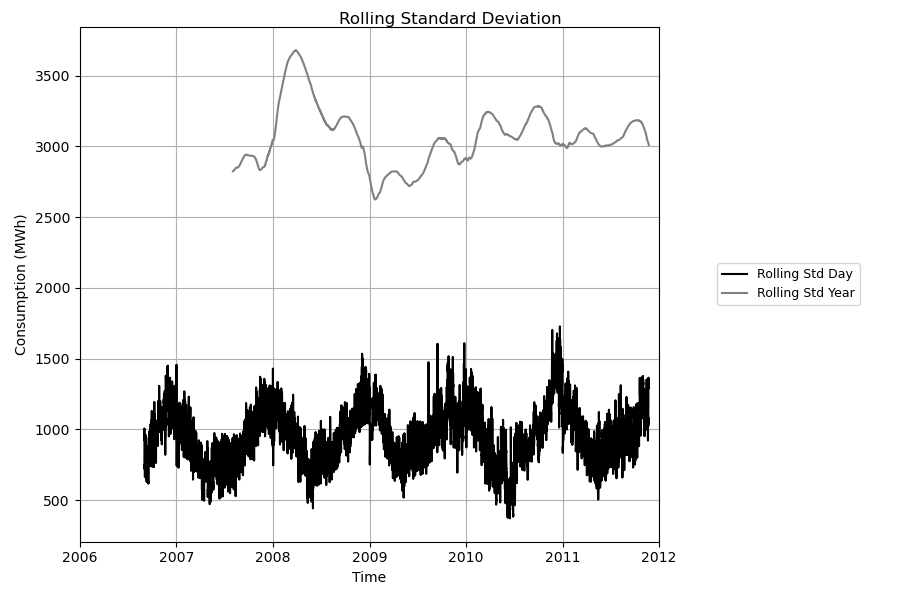

In [97]:
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs


pax.plot(df_plot.index, df_plot["rol_std_day"], label="Rolling Std Day",
         color="black", linewidth=1.5)


pax.plot(df_plot.index, df_plot["rol_std_year"], label="Rolling Std Year",
         color="grey", linewidth=1.5)


years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
years_fmt = mdates.DateFormatter('%Y')


# format the ticks
pax.xaxis.set_major_locator(years)
pax.xaxis.set_major_formatter(years_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)


datemin = np.datetime64(df_plot.index[0], 'Y')
datemax = np.datetime64(df_plot.index[-1], 'Y') + np.timedelta64(1, 'Y')
pax.set_xlim(datemin, datemax)


pax, lax = axs
pax.set_ylabel("Consumption (MWh)")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Rolling Standard Deviation")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])

By looking at the plot, we can see that the yearly rolling standard deviation is fluctuating thoughout the year and usually reaches its peak during the months of December and January when the consumption is at its highest.

Another interesting fact is the yearly rolling standard deviation that was very high during the year 2008. There could be a link with the economic crisis where oil prices went up which caused an important variation of electricity consumption.

Now that we had a first look at our data, we can draw the following conclusisons;
- The data is seasonal and thus a SARIMA model can be efficient to perform predictions.
- The hourly timestep is very noisy and it can become difficult to build a model that can predict the price hourly
- The data follows the same pattern throughout the years

In order to put ourself in a "real life case", we will perform monthly predictions that enable grid operators to better manage their energy assets for the upcoming month. Our data being at a montly timestep, a monthly resample will be necessary. Our data having strong seasonality we will do our first predictions with a SARIMA model.

Now, before jumping to building a model we need to verify that our timeseries is stationary. It musn't have any trend nor seasonality and the standard deviation must be constant.



Here we used the **sum** method for monthly resampling because we are dealing with energy data. We are also dividing by 1e6 to work in TWh instead of MWh to better scale our axis when plotting the monthly data. Here is the result

<IPython.core.display.Javascript object>


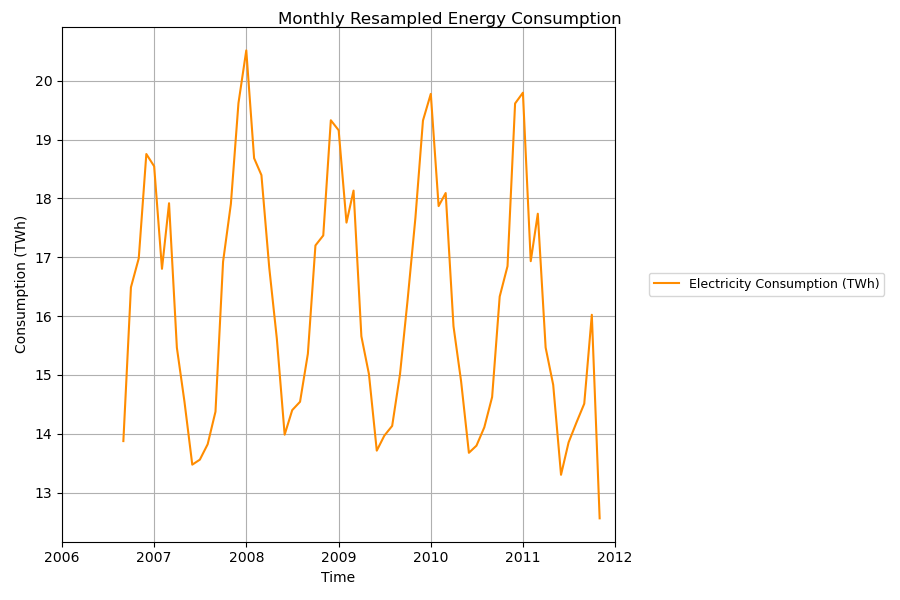

In [99]:
start = "2006-12-01 00:00:00"
end = "2006-12-01 23:00:00"


df_plot = monthly_df
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [6, 1]})


pax, _ = axs
pax.plot(df_plot.index, df_plot["consumption_sib"], label="Electricity Consumption (TWh)",
         color="darkorange", linewidth=1.5)


years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
pax.xaxis.set_major_locator(years)
pax.xaxis.set_major_formatter(years_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'Y')
datemax = np.datetime64(df_plot.index[-1], 'Y') + np.timedelta64(1, 'Y')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Consumption (TWh)")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("Monthly Resampled Energy Consumption")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])

# Augmented Dicky Fuller Test for stationarity

Let us now perform the ADF test to see if the series is stationary. In this unilateral test, the null hypothesis is that the data is not stationary. The null hypothesis will be rejected if the p-value is below 0.05. If it is the case, we can admit that the timeseries is stationary. If the test result doesn't confirm it we will have to perform some transformation on our dataset. It will be very likely the case since there is a clear presence of seasonality in our dataset.

In [100]:
# For more information about the functions used for the ADF test, go to 
# the Functions section of the Notebook
tpl_adf = adfuller(monthly_df['consumption_sib'].dropna(), autolag='AIC') # returns a tuple
print_adf(tpl_adf)  

Test Statistic                -0.561907
p-value                        0.879359
#Lags Used                    11.000000
Number of Observation Used    51.000000
dtype: float64
Critical value 1%: -3.5656240522121956
Critical value 5%: -2.920142229157715
Critical value 10%: -2.598014675124952


We can see that the series is not stationary since the p-value is equal to 0.8793. A way to make our timeseries stationary it to apply a simple differenciation which means that for every cell in our dataset we will substract the previous value.

$Y_{diff} = Y_{t}-Y_{t-1}$

The only drawback of this method is that we will lost the first value present in the dataset

# Differenciation

In [63]:
monthly_df['diff_consumption_sib'] = monthly_df['consumption_sib'].diff()
tpl_adf = adfuller(monthly_df['diff_consumption_sib'].dropna(), autolag='AIC')
print_adf(tpl_adf)  

Test Statistic                -1.770647
p-value                        0.395129
#Lags Used                    11.000000
Number of Observation Used    50.000000
dtype: float64
Critical value 1%: -3.568485864
Critical value 5%: -2.92135992
Critical value 10%: -2.5986616


We can see that the data is still not stationary because the p-value is equal to 0.3951 and is still above 0.05.
Let's perform a second differenciation and see where we land.

In [64]:
monthly_df['diff2_consumption_sib'] = monthly_df['diff_consumption_sib'].diff()
tpl_adf = adfuller(monthly_df['diff2_consumption_sib'].dropna(), autolag='AIC') # returns a tuple
print_adf(tpl_adf)  

Test Statistic                -4.759499
p-value                        0.000065
#Lags Used                    11.000000
Number of Observation Used    49.000000
dtype: float64
Critical value 1%: -3.5714715250448363
Critical value 5%: -2.922629480573571
Critical value 10%: -2.5993358475635153


According to the p-value of the ADF test that is equal to 0.0001 (taking four decimals), our timeseries is stationary.

Now that the timeseries is stationary, we will perform an autocorrelation and partial autocorrelation plot in order to see what will be the order of the Autoregressive and Moving Average part of the model.

16


D:\logiciel\Anaconda\envs\ml_work\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


<IPython.core.display.Javascript object>


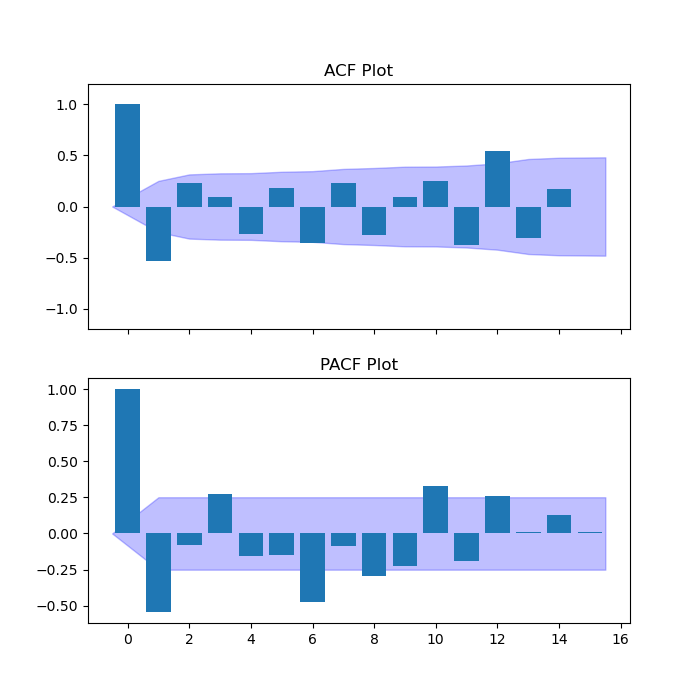

In [65]:
# For more information about the functions use for the ACF and PACF go to the Utils section of
# the Notebook
plot_cf(monthly_df['diff2_consumption_sib'].dropna())

We can see on the ACF and PACF plot that we have a strong coefficient for lag 1 of approximately -0.5. The following lags are not significant according the the confidence interval. We will thus have an order of (1,2,1) for the ARIMA part of the model.

Concerning the seasonal part of the model, We  observe a strong coefficient for lag 12 in the ACF plot which suggets a season of S = 12 and since this lag is positive it suggests P = 1 and Q = 0.

The model that we will retain is therefore the following:

$(p, d, q)x(P, D, Q, m) = (1,2,1)x(1,0,0,12)$

# Get training and testing set

We will try to forecast monthly energy consumption for the year of 2011 between the month of january and november. We will first do a one shot prediciton for all 11 months and after perform rolling forecast predicitons (month by month).

In [66]:
y = monthly_df['consumption_sib'].dropna()
train_end = datetime(2010,12,31)
test_end = datetime(2011,11,30)

train_data = y[:train_end]
test_data = y[train_end + timedelta(days=1):test_end]

# Fitting SARIMA model

In [67]:
order = (1,2,1)
sea_order = (1,0,0,12)
model = SARIMAX(train_data, order=order, seasonal_order=sea_order)


In [68]:
# Fitting the model and retrieving computing time

start = time()
model_fit = model.fit()
end = time()
print('model fitting time {:3.4f} s'.format(end-start))

model fitting time 0.2055 s


In [69]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     consumption_sib   No. Observations:                   52
Model:             SARIMAX(1, 2, 1)x(1, 0, [], 12)   Log Likelihood                 -53.412
Date:                             Thu, 18 Feb 2021   AIC                            114.823
Time:                                     15:56:56   BIC                            122.471
Sample:                                 09-01-2006   HQIC                           117.736
                                      - 12-01-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3326      0.166     -1.998      0.046      -0.659      -0.006
ma.L1         -0.9993      0.578     -1.728      0.084      -2.133       0.134
ar.S.L12       0.9398      0.031     30.174      0.000       0.879       1.001
sigma2         0.2899      0.192      1.512      0.131      -0.086       0.666
===================================================================================
Ljung-Box (Q):                       60.36   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.02   Prob(JB):                         1.00
Heteroskedasticity (H):               0.54   Skew:                            -0.00
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
pred_index = pd.date_range(start="2011-01-01", end="2011-11-01", freq='MS')

predictions = model_fit.forecast(len(test_data)) # Performing predictions
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data-predictions # Retrieving residuals

<IPython.core.display.Javascript object>


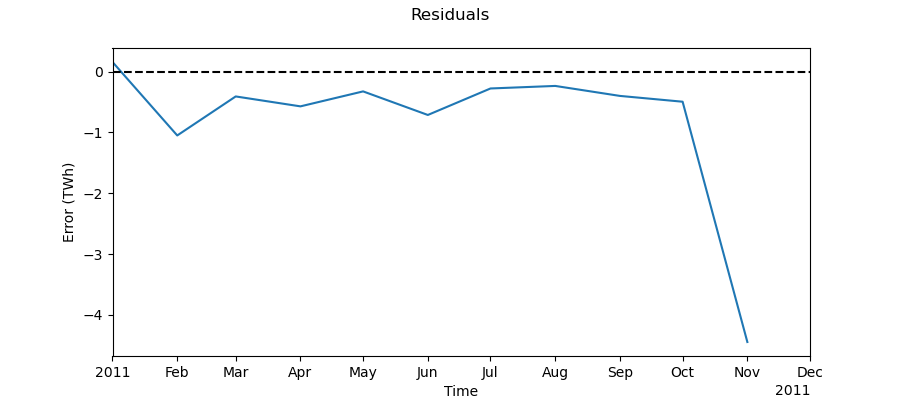

C:\Users\goget\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


Text(0.5, 0.98, 'Residuals')

In [75]:
fig = plt.figure(figsize=(9,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')

ax = fig.add_subplot(111)

months = mdates.MonthLocator()
month_fmt = mdates.ConciseDateFormatter('%m')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)

datemin = np.datetime64(residuals.index[0], 'M')
datemax = np.datetime64(residuals.index[-1], 'M') + np.timedelta64(1, 'M')
ax.set_xlim(datemin, datemax)



ax.set_ylabel("Error (TWh)")
ax.set_xlabel("Time")


fig.suptitle('Residuals')

By looking at the graph we can clearly see that the model is not that bad with an error that is around 1 TWh each month except for november. Let's plot the actual data and the predictions to have a better idea of the model. We will also calculate the MAPE and the RMSE.

<IPython.core.display.Javascript object>


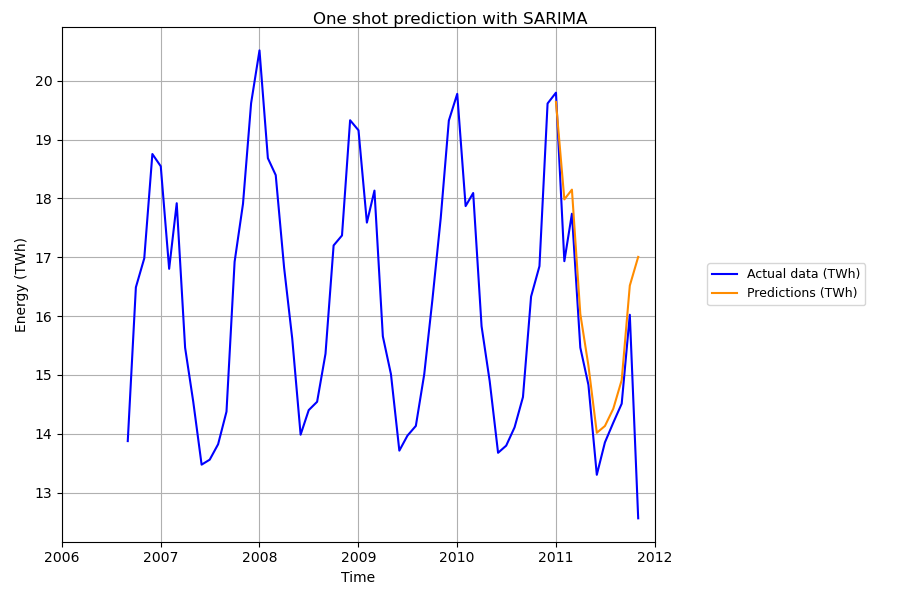

In [102]:

monthly_df['predictions'] = predictions

df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(df_plot.index, df_plot["consumption_sib"], 
         label="Actual data (TWh)",
         color="blue", linewidth=1.5)


pax.plot(df_plot.index, df_plot["predictions"], 
         label="Predictions (TWh)",
         color="darkorange", linewidth=1.5)



#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
pax.xaxis.set_major_locator(years)
pax.xaxis.set_major_formatter(years_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'Y')
datemax = np.datetime64(df_plot.index[-1], 'Y') + np.timedelta64(1, 'Y')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Energy (TWh)")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("One shot prediction with SARIMA")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])

In [103]:

print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_data)),4) * 100, '%')
print('Root Mean Square Error :', np.sqrt(np.mean(residuals**2)))


Mean Absolute Percent Error:  5.96 %
Root Mean Square Error : 1.4315651996448002


The model is quite accurate with a MAPE of 5.96% which is quite good. We can see on the plot that we are able to predict the energy consumption although it seems that our model overestimates it. We seem to always be predicting a higher consumption which is not a bad thing for a grid operators. In some cases it may be better to have to turn down some production units rather than having to turn on others or buy electricity from another country to meet the demand.

# Rolling forecast origin

Let's know try to use the rolling forecast method. The rolling forecast method does one timestep prediction and takes into account the actual value in order to predict the following value. 

In [104]:

rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = y[:train_end]
    model = SARIMAX(train_data, order=order, seasonal_order=sea_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred


In [105]:
rolling_residuals = test_data - rolling_predictions

<IPython.core.display.Javascript object>


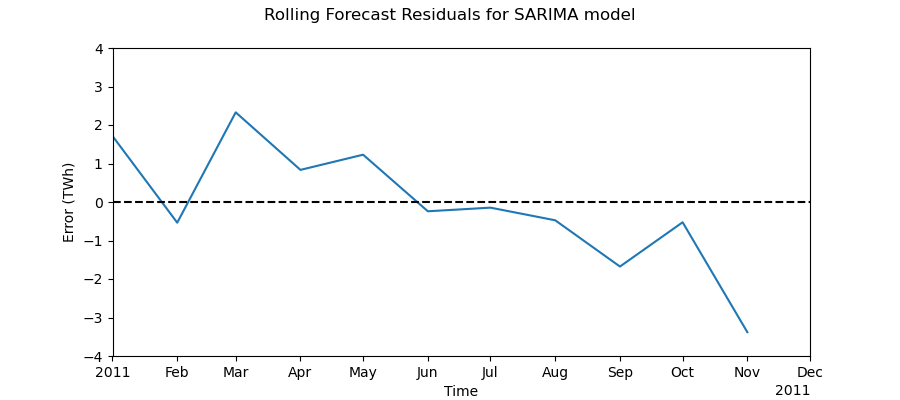

C:\Users\goget\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


Text(0.5, 0.98, 'Rolling Forecast Residuals for SARIMA model')

In [106]:
fig = plt.figure(figsize=(9,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')

ax = fig.add_subplot(111)

months = mdates.MonthLocator()
month_fmt = mdates.ConciseDateFormatter('%m')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)

datemin = np.datetime64(residuals.index[0], 'M')
datemax = np.datetime64(residuals.index[-1], 'M') + np.timedelta64(1, 'M')
ax.set_xlim(datemin, datemax)
ax.set_ylim(-4,4)



ax.set_ylabel("Error (TWh)")
ax.set_xlabel("Time")


fig.suptitle('Rolling Forecast Residuals for SARIMA model')

Suprisingly, the rolling forecast method as higher errors than the one shot predictions but that doesn't make it a worst model. The thing about this model is that it underestimated the consumption during the the month of March April and May but underestimated it for the end of the year while the one shot prediction was constantly overestimating the energy consumption.

Let's plot the predictions and the actual data to get a better idea of the results.

<IPython.core.display.Javascript object>


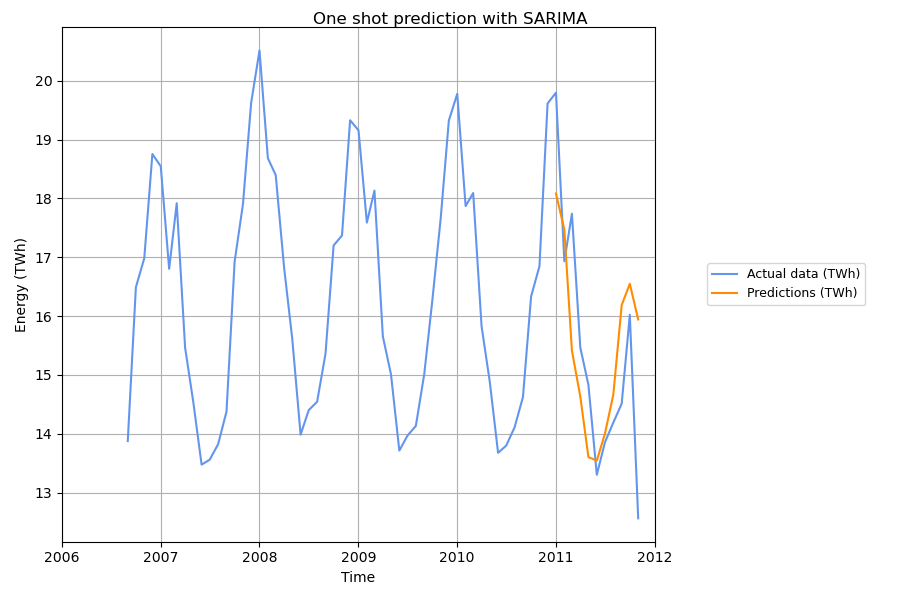

In [108]:
monthly_df['rol_predictions'] = rolling_predictions

df_plot = monthly_df.copy()
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(df_plot.index, df_plot["consumption_sib"], 
         label="Actual data (TWh)",
         color="cornflowerblue", linewidth=1.5)


pax.plot(df_plot.index, df_plot["rol_predictions"],
         label="Predictions (TWh)",
         color="darkorange", linewidth=1.5)


#pax.grid(True)

years = mdates.YearLocator() 
months = mdates.MonthLocator()
day = mdates.HourLocator()
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
pax.xaxis.set_major_locator(years)
pax.xaxis.set_major_formatter(years_fmt)
# pax.xaxis.set_minor_locator(months)
pax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
pax.grid(True)

datemin = np.datetime64(df_plot.index[0], 'Y')
datemax = np.datetime64(df_plot.index[-1], 'Y') + np.timedelta64(1, 'Y')
pax.set_xlim(datemin, datemax)

pax, lax = axs
pax.set_ylabel("Energy (TWh)")
pax.set_xlabel("Time")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)

# ----------------

fig.suptitle("One shot prediction with SARIMA")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0,0,1,0.98])


In [109]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(rolling_residuals/test_data)),3)*100, '%')
print('Root Mean Square Error :', np.sqrt(np.mean(rolling_residuals**2)))

    

Mean Absolute Percent Error:  7.9 %
Root Mean Square Error : 1.528062003726806


We can see that the rolling method is not as good as the one shot prediction regarding the MAPE. When we look at the RMSE the one shot prediction method outscores the rolling forecast by 0.1 TWh which is again not that much. If we put ourselves in the shoes of a grid operator, having these error is not that a big of problem considering that they have at their disposal controllable energy sources and a regulation mechanism to ensure a balance between electricy production and consumption.

# **CONCLUSION**


Throughout this first notebook we were able to perform a first analysis of energy consumption in SIBERIA
We were able to perform a statistical analysis of the timeseries in order to choose the best model possible.
Finally we wera able to buil a SARIMA model that could effectively predict energy consumption for an entire month or multiple ones using the rolling forecast method or the one shot predictions. Depending on what a grid operator would want to do a method can be better than the other one. 

Potential following steps for the project would be:
 * Use a grid search search to find the best configuration model
 * Perform a cross analysis of the consumption with the prices in order to identify some kind of correlation
 * Investigate how the consumption and prices behave for the euro zone
 * And many other things that I let you imagine...
 
 
 
 
 
 Voila! this is the end of notebook 1, the notebook 2 will be exploring the XGBoostRegressor method to forecast energy consumtpion. 
 
 I hope you enjoyed the reading and feel free to contact me if you have any questions or if you are interested on working on a project.
<br><br><br>


_"Keep moving, Keep growing, Keep learning and see you at work"_ <br>
**D.W.**


**Contact**:<br>
* [Linkedin](https://www.linkedin.com/in/seydou-dia-325b04139)
* @:seydou.dia@insa-lyon.fr<br>
<br>



**References used to conduct the project** :
* Ritvikmath, (2020). _Time Series Talk : Augmented Dicky Fuller Test_. Youtube video
* Ritvikmath, (2020). _Unit Roots_. Youtube Video
* Michael Fumery, (2020). _Timeseries SARIMA_. Kaggle Notebook
* Vincent Lefieux, (2020). _Modélisation de série temporelles_. Open Classroom
* Bernard Roux, (2019). _Probablity & Statistics_. INSA Lyon
* Jason Brownlee, (2018). _A gentle introduction to SARIMA for timeseries forecasting in Python_. ML Mastery
* Wes McKinney, (2017). _Python for Data Analysis_. O'reilly


**END OF NOTEBOOK**